# Week 5: Document Processing with Visual Citations

> **Prerequisites**: Please make sure to install the `poppler` library before continuing. See [installation instructions here](https://poppler.freedesktop.org).

In this notebook, we'll apply structured data extraction to PDF documents, using language models to extract information while maintaining visual references to source material. This extends our work with metadata from previous notebooks to handle more complex document formats.

## Why this matters

Many RAG applications need to process structured documents like invoices, reports, and forms. When extracting information from these sources, maintaining citation integrity becomes crucial for user trust. Without clear references to source information, users can't verify the AI's output, limiting adoption in high-stakes scenarios. Visual citations provide an intuitive way to show exactly where information was found.

## What you'll learn

Through hands-on work with PDF invoices, you'll discover how to:

1. Process Documents with OCR
   - Convert PDFs to structured text with spatial information
   - Maintain document hierarchy for reliable citations
   - Preserve layout information for visual references

2. Extract Structured Information
   - Implement validation for citation integrity
   - Extract entities and relationships with source tracking
   - Apply the same metadata principles from previous notebooks to PDFs

3. Create Visual Citations
   - Generate bounding boxes that highlight source information
   - Build transparent extraction pipelines that earn user trust
   - Improve RAG outputs with visual verification

By the end of this notebook, you'll have a complete document processing pipeline that extracts structured information while maintaining citation integrity - essential for real-world RAG deployments.

## Setting up our OCR Pipeline

When working with document data, there's a fundamental challenge: raw text alone misses crucial context that humans intuitively grasp from layout. OCR combined with image processing bridges this gap by creating a spatial understanding of information.

Think about how you read an invoice - you don't just process the words sequentially. You understand that text in the top-right corner is likely the invoice number, larger text might be headings, and items grouped together probably belong to the same entity. This spatial relationship provides implicit meaning beyond the words themselves.

By providing an image of each page in the PDF document, we capture this visual context that would otherwise be lost. The OCR pipeline doesn't just extract text; it preserves where information appears on the page, which helps our vision language model understand relationships between elements just as humans do.


In [68]:
from docling.backend.docling_parse_backend import DoclingParseDocumentBackend
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import (
    EasyOcrOptions,
    OcrMacOptions,
    PdfPipelineOptions,
    RapidOcrOptions,
    TesseractCliOcrOptions,
    TesseractOcrOptions,
)
from docling.document_converter import DocumentConverter, PdfFormatOption
from pathlib import Path


def parse_pdf(pdf_path, ocr_type="tesseract_cli"):
    """Parse a PDF document and return the content in the specified format.

    Args:
        pdf_path: Path to the PDF file
        ocr_type: Type of OCR engine to use
        export_format: Format to export the document to (currently only supports "markdown")

    Returns:
        Parsed document content in the specified format
    """
    input_doc = Path(pdf_path)

    # Create pipeline options
    pipeline_options = PdfPipelineOptions()
    pipeline_options.do_ocr = True
    pipeline_options.do_table_structure = True
    pipeline_options.table_structure_options.do_cell_matching = True

    # Set OCR options based on type
    ocr_options_map = {
        "easy": EasyOcrOptions(force_full_page_ocr=True),
        "tesseract": TesseractOcrOptions(force_full_page_ocr=True),
        "mac": OcrMacOptions(force_full_page_ocr=True),
        "rapid": RapidOcrOptions(force_full_page_ocr=True),
        "tesseract_cli": TesseractCliOcrOptions(force_full_page_ocr=True),
    }
    pipeline_options.ocr_options = ocr_options_map.get(
        ocr_type, ocr_options_map["tesseract_cli"]
    )

    # Create converter and process document
    converter = DocumentConverter(
        format_options={
            InputFormat.PDF: PdfFormatOption(
                pipeline_options=pipeline_options,
            )
        }
    )

    return converter.convert(input_doc).document


doc = parse_pdf("./data/invoice.pdf")


In [69]:
doc.export_to_markdown()[:100]

'<!-- image -->\n\nAzure Interior 4557 De Silva St Fremont CA 94538 United States\n\nYourCompany, Mitchel'

Once we've processed the document, we can convert it to a format where each text element or table has a unique identifier. This chunk ID system lets us refer back to specific document elements when extracting information.

In [71]:
from rich import print
from docling.datamodel.document import DoclingDocument


def generate_citation_items(doc: DoclingDocument):
    id_to_item = {}
    formatted_text = ""
    curr = 0
    for text in doc.texts:
        id_to_item[curr] = text
        formatted_text += f"<chunk id = {curr}>\n{text.text}\n</chunk>\n"
        curr += 1

    for table in doc.tables:
        formatted_text += (
            f"\n<chunk id = {curr}>\n{table.export_to_markdown()}\n</chunk>\n"
        )
        id_to_item[curr] = table
        curr += 1

    return id_to_item, formatted_text


id_to_item, markdown_output = generate_citation_items(doc)
print(markdown_output[:400])

<chunk id = 0>
Ogure
</chunk>
<chunk id = 1>
Azure Interior 4557 De Silva St Fremont CA 94538 United States
</chunk>
<chunk id = 2>
YourCompany, Mitchell Admin 215 Vine St Scranton PA 18503 United States
</chunk>
<chunk id = 3>
Invoice INV/2023/03/0008
</chunk>
<chunk id = 4>
(870)-931-0505 azure.Interior24@example.com http://www.azure-interior.com
</chunk>
<chunk id = 5>
Page: 1/1
</chunk>

<chun

To provide images to GPT-4o, we need to provide as a base-64 encoded image. To do so, we'll implement two functions - one that converts our PDF to a list of images and another that converts it to a base64 representation

In [72]:
from io import BytesIO
import base64
from PIL import Image
from pdf2image import convert_from_path


def encode_pil_to_base64(pil_image):
    """
    Encode a PIL Image to a base64 string in PNG format

    Args:
        pil_image: PIL Image object

    Returns:
        str: Base64 encoded string of the image in PNG format
    """
    # Create a bytes buffer for the image
    buffered = BytesIO()

    # Save the image as PNG to the buffer
    pil_image.save(buffered, format="PNG")

    # Get the binary data from the buffer
    img_bytes = buffered.getvalue()

    # Encode to base64
    img_base64 = base64.b64encode(img_bytes).decode("utf-8")

    # Add the PNG mime-type prefix
    return f"data:image/png;base64,{img_base64}"


def extract_images_from_pdf(pdf_path: str) -> list[Image.Image]:
    """
    Extracts images from a PDF file and returns a list of PIL images.
    """
    return convert_from_path(pdf_path)

Let's see this in action below and let's convert our PDF to a list of images

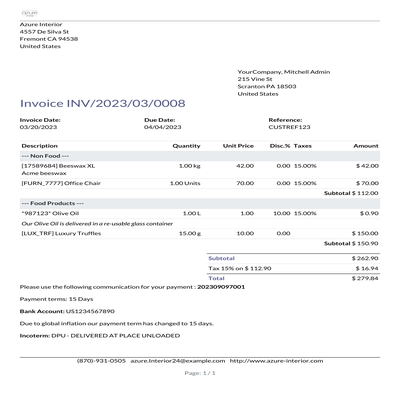

In [73]:
images = extract_images_from_pdf("./data/invoice.pdf")
# Display the first image
if images:
    for image in images:
        # Resize image to 400x400
        resized_image = image.resize((400, 400), Image.LANCZOS)
        display(resized_image)

In [82]:
encode_pil_to_base64(images[0])[:200]

'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABnUAAAkjCAIAAABYnF2RAAEAAElEQVR4nOzdB1RVR9/3/Tl0UARBaaJgA8UCauzYa+yJYk0EY0/VxNiTkJhYo2KLvV2a2LuxiyjGrkGxIWpQAQELTXo574rzvOc5z6GIGxSN38/KutZm9uy952wgd/jdM/'

Let's now see how we might implement this along with a function call today so that we can get citations

## Implementing Structured Extraction with Citations

Now that we have our document broken down into chunks with unique IDs, we can build a extraction system that validates citations as part of the process. 

We'll use Pydantic models with custom validators to ensure all extracted information includes valid citations.

Our model structure includes:
- Base `CitableItem` class that requires citations
- `Entity` Information with company details



In [75]:
from pydantic import BaseModel, field_validator, ValidationInfo

class CitableItem(BaseModel):
    citations: list[int]

    @field_validator("citations")
    def validate_citations(cls, v, info: ValidationInfo):
        citation_ids = info.context["id_to_item"].keys()
        invalid_citations = [citation for citation in v if citation not in citation_ids]
        if invalid_citations:
            raise ValueError(
                f"Invalid citations were provided: {invalid_citations}. Please make sure that the citations you provide are valid."
            )
        return v

In [53]:
CitableItem.model_validate_json('{"citations": [1, 2, 3]}', context={"id_to_item": {1: "test", 2: "test", 3: "test"}})

CitableItem(citations=[1, 2, 3])

In [54]:
CitableItem.model_validate_json('{"citations": [1, 2, 3]}', context={"id_to_item": {1: "test", 2: "test"}})

ValidationError: 1 validation error for CitableItem
citations
  Value error, Invalid citations were provided: [3]. Please make sure that the citations you provide are valid. [type=value_error, input_value=[1, 2, 3], input_type=list]
    For further information visit https://errors.pydantic.dev/2.10/v/value_error

We can see that when we have citations that are provided which don't map to the provided ids in the context itself, then it throws an error

In [76]:
import instructor
import openai
from rich import print
from typing import Optional

class Entity(CitableItem):
    name: str
    address: Optional[str] = None
    phone: Optional[str] = None
    email: Optional[str] = None
    website: Optional[str] = None


class ExtractedData(BaseModel):
    entities: list[Entity]


def extract_entities(client: instructor.Instructor, pdf_path ):
    """Extract line items from the invoice document."""
    doc = parse_pdf(pdf_path)
    id_to_item, markdown_output = generate_citation_items(doc)
    images = extract_images_from_pdf(pdf_path)
    
    return client.chat.completions.create(
        model="gpt-4o-2024-08-06",
        messages=[
            {
                "role": "system",
                "content": "Extract all corporate entities from the invoice document that are explicitly mentioned",
            },
            {
                "role": "user",
                "content": """
Here is the markdown representation of the invoice document with chunk ids for you to use as citations for each value extracted

<markdown>
{{ markdown_output }}
</markdown>


""",
            },
            {
                "role": "user",
                "content": [
                    instructor.Image.from_base64(encode_pil_to_base64(image)) for image in images
                ]
            }
        ],
        context={"id_to_item": id_to_item, "markdown_output": markdown_output},
        response_model=ExtractedData,
    )


pdf_path = "./data/invoice.pdf"
client = instructor.from_openai(openai.OpenAI())
items = extract_entities(client, pdf_path)
print(items)


ExtractedData(
    entities=[
        Entity(
            citations=[1, 4],
            name='Azure Interior',
            address='4557 De Silva St Fremont CA 94538 United States',
            phone='(870)-931-0505',
            email='azure.Interior24@example.com',
            website='http://www.azure-interior.com'
        ),
        Entity(
            citations=[2],
            name='YourCompany, Mitchell Admin',
            address='215 Vine St Scranton PA 18503 United States',
            phone=None,
            email=None,
            website=None
        )
    ]
)

## Visualizing Bounding Boxes for Citations

The final step is to show where information was found in the original document. While our metadata filtering notebook relied on structured fields, document processing needs to maintain visual references to build user trust.

This visualization step is crucial for bridging the gap between raw data extraction and user-facing applications. Just as we provided filters to help users find products matching specific criteria, these visual citations help users verify the accuracy of extracted information.

In [77]:
from PIL import ImageDraw
from docling.datamodel.document import Page, TextItem, TableItem
from PIL import Image

from typing import List, Union


def draw_bbox_on_image(image, bbox, page_height, page_width, padding=20):
    """Draw bounding box on a copy of the image"""
    # Make a copy so we don't modify original
    img_copy = image.copy()

    draw = ImageDraw.Draw(img_copy)

    img_width = img_copy.width
    img_height = img_copy.height

    # Calculate scaling factors
    x_scale = img_width / page_width
    y_scale = img_height / page_height

    # Convert bbox to top-left coordinates using PDF height
    tl_bbox = bbox.to_top_left_origin(page_height)

    # Scale the coordinates from PDF units to image pixels
    left = tl_bbox.l * x_scale
    top = tl_bbox.t * y_scale
    right = tl_bbox.r * x_scale
    bottom = tl_bbox.b * y_scale

    # Draw rectangle
    draw.rectangle(
        [(left - padding, top - padding), (right + padding, bottom + padding)],
        outline="red",
        width=2,
    )
    return img_copy


def generate_bboxes(
    items: List[Union[TextItem, TableItem]],
    images: List[Image.Image],
    pages: List[Page],
):
    images = [image.copy() for image in images]
    for item in items:
        for prov in item.prov:
            page_idx = prov.page_no - 1  # Convert 1-based to 0-based indexing
            page = pages[page_idx + 1]
            bbox = prov.bbox
            images[page_idx] = draw_bbox_on_image(
                images[page_idx], bbox, page.size.height, page.size.width
            )

    return images

In [79]:
def visualize_bboxes_from_pdf(doc, pdf_path, id_to_item, all_items):
    """
    Visualizes bounding boxes on PDF images based on item citations.
    
    Args:
        doc: The document object containing pages
        pdf_path: Path to the PDF file
        id_to_item: Dictionary mapping item IDs to their corresponding items
        all_items: Set of item IDs to visualize
        
    Returns:
        The first image with bounding boxes drawn
    """
    pages = doc.pages
    images = extract_images_from_pdf(pdf_path)
    return generate_bboxes([id_to_item[i] for i in all_items], images, pages)
    

pdf_path = "./data/invoice.pdf"
client = instructor.from_openai(openai.OpenAI())
items = extract_entities(client, pdf_path)

all_items = set()


for entity in items.entities:
    for item_id in entity.citations:
        all_items.add(item_id)

print(all_items)

{1, 2, 4}

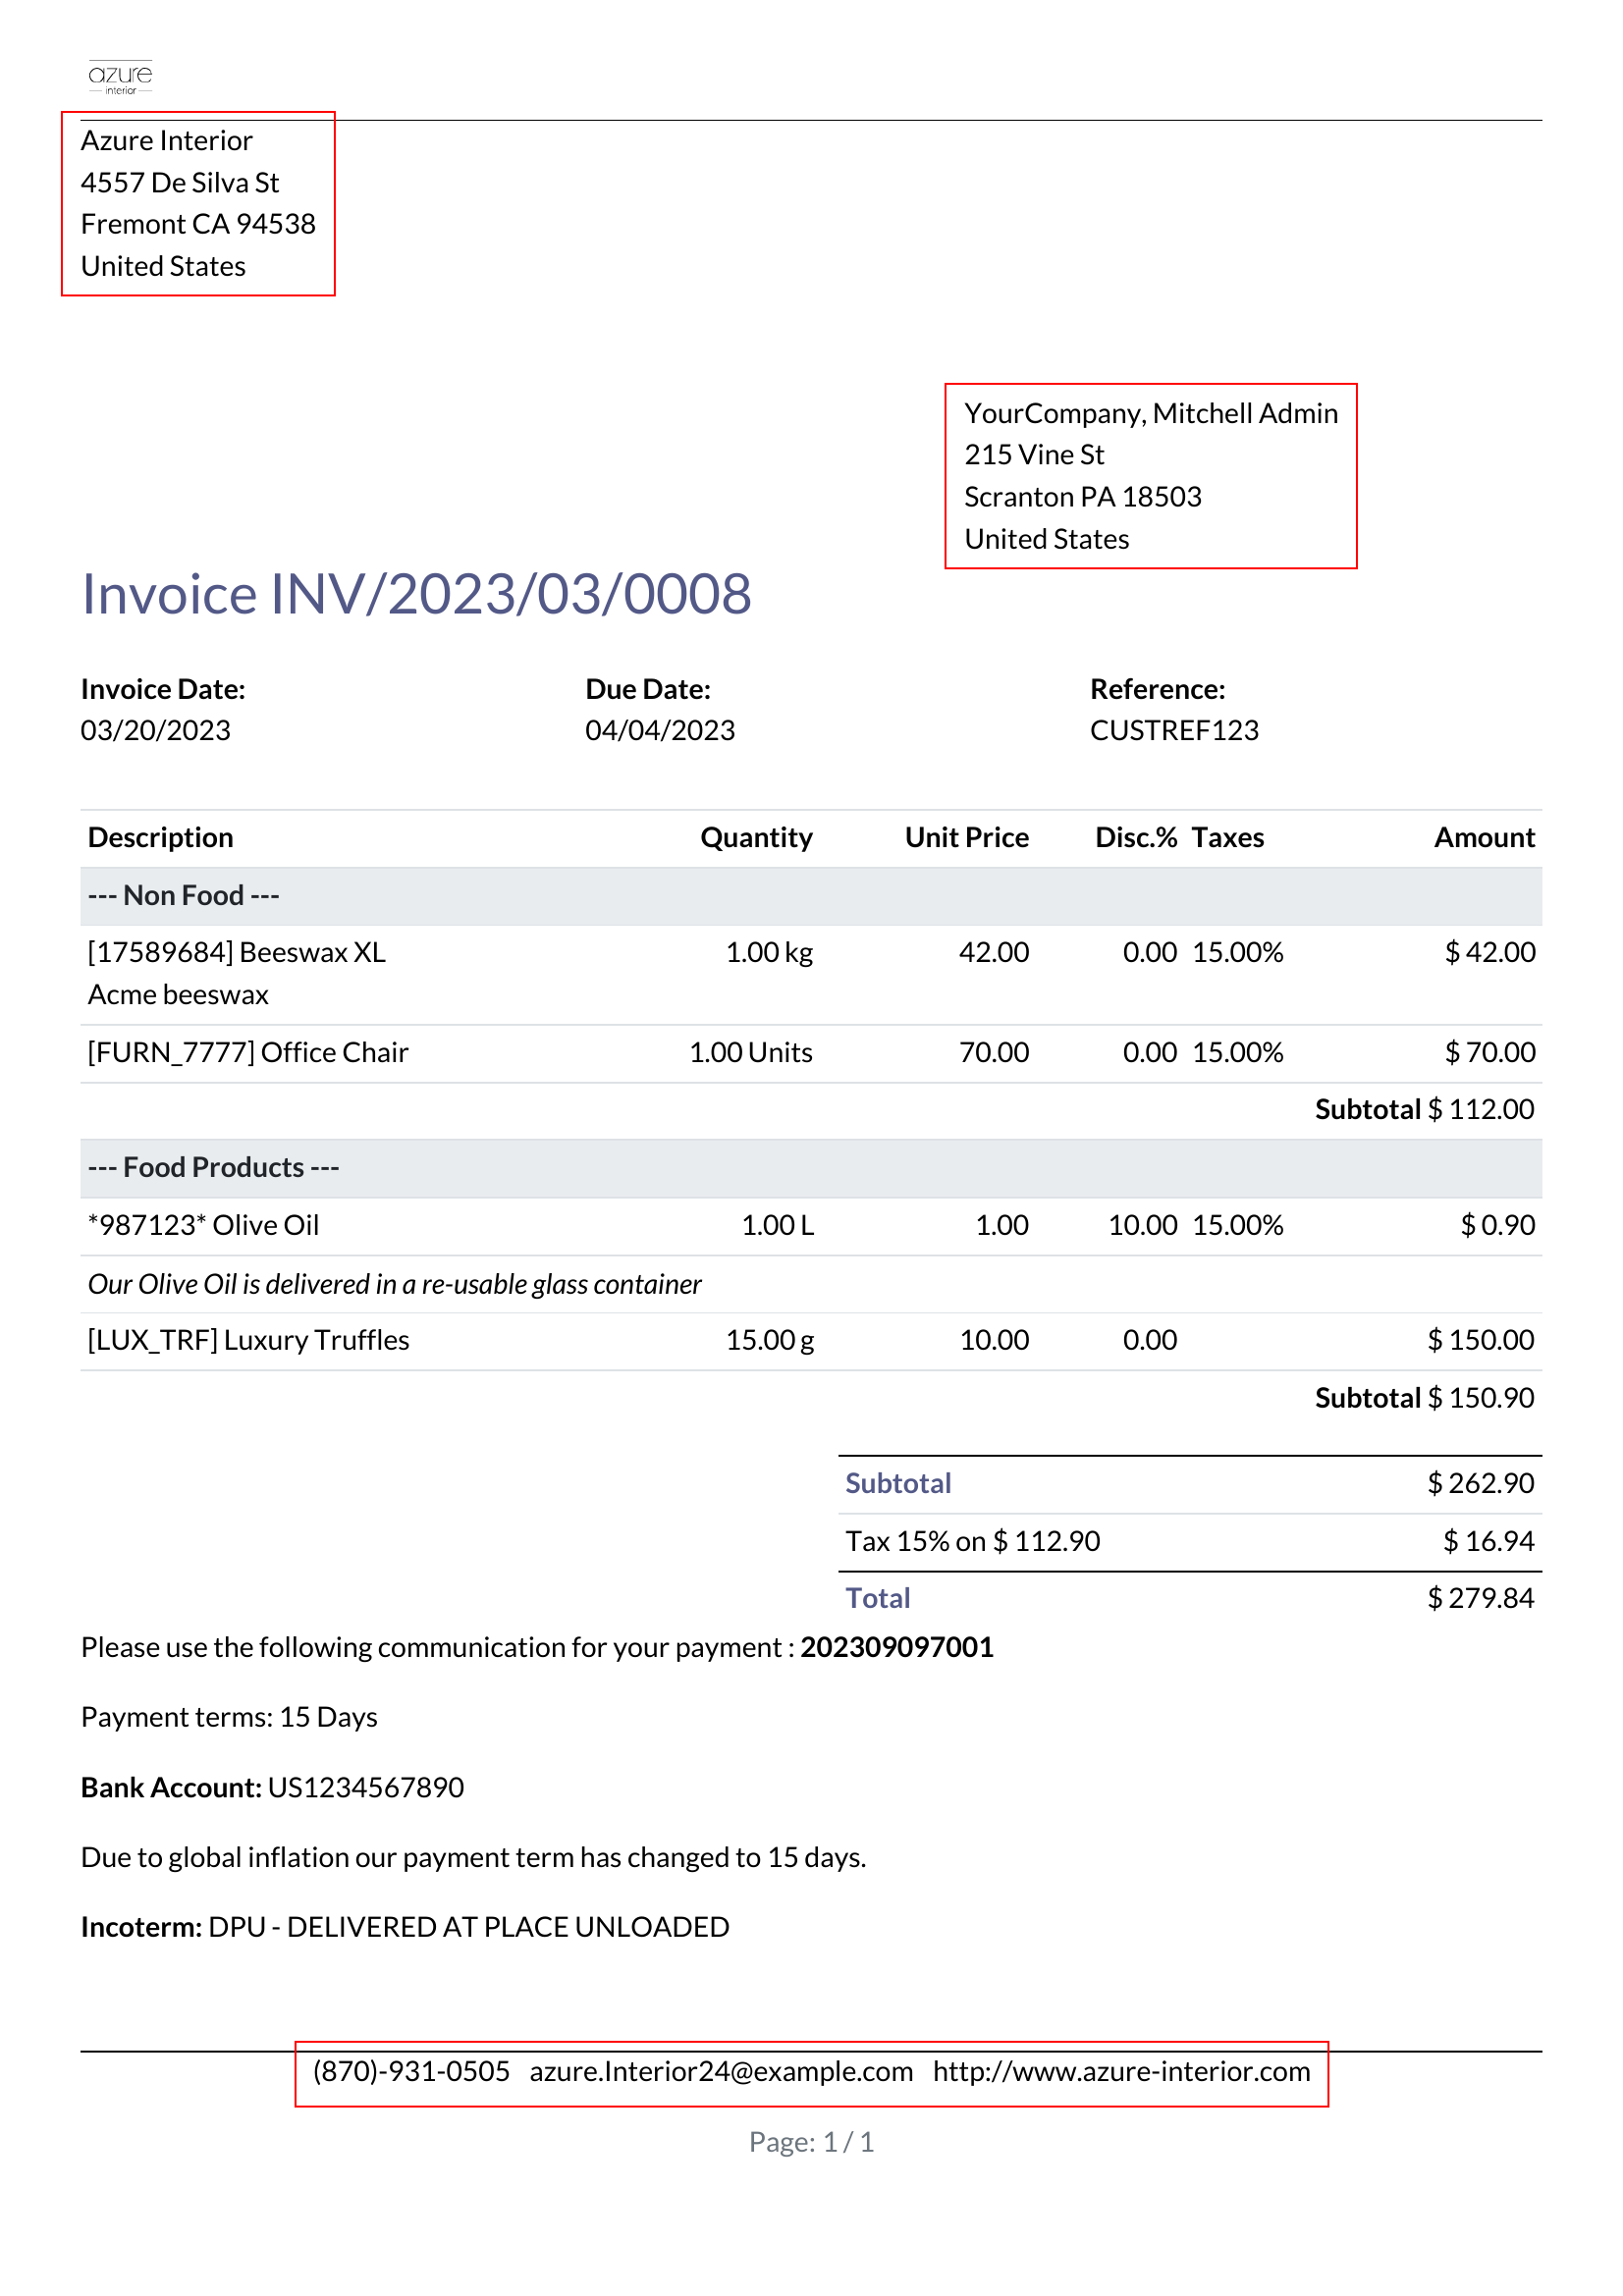

In [80]:
images = visualize_bboxes_from_pdf(doc, pdf_path, id_to_item, all_items)
for image in images:
    display(image)

## Conclusion

In this notebook, we've built a document processing pipeline that extracts structured information from PDFs while maintaining visual citations. This approach complements our previous work with structured metadata and query understanding by adding support for complex document formats. Being able to visually display citations for extracted content is crucial for getting users to trust the generated outputs from our language model.

This work builds directly on Week 4's query understanding by providing the structured information needed to answer document-specific questions. As we move toward Week 6's tool selection, these document processing capabilities will become another tool in our arsenal for systematically improving RAG applications.

By maintaining citation integrity throughout the extraction process, we create RAG systems that users can trust with high-value document processing tasks - extending our structured data approach to more complex information sources.